# BavarianCrops

In [32]:
import sys
sys.path.append("..")
from argparse import Namespace
from data import BavarianCrops, BreizhCrops
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score, recall_score, precision_score
import matplotlib.pyplot as plt


from earlyrnn import EarlyRNN
import torch
import os
import pandas as pd
from datetime import datetime
import numpy as np

import datetime
import seaborn

data_root = "../elects_data"
device = "cuda" if torch.cuda.is_available() else "cpu"

In [33]:
test_ds = BavarianCrops(root=data_root,partition="eval", sequencelength=150, return_ids=True)

nclasses = 7
input_dim = 13
model = EarlyRNN(nclasses=nclasses, input_dim=input_dim).to(args.device)
model.load_state_dict(torch.load("../snapshots/bavariancrops.pth"))
model.eval()

no dataset found in ../elects_data/holl. downloading...
[=                                                 ]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=======                                           ]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=============                                     ]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[======================                            ]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[============================                      ]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================================                ]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=======================================           ]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=============================================     ]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Load Day of Year per Field

In [38]:
npydoy_url = "https://elects.s3.eu-central-1.amazonaws.com/bavariancropsdoys.npy"
npydoy = 'bavariancropsdoys.npy'

if not os.path.exists(npydoy):
    !wget $npydoy_url
    
doys_dict = np.load(npydoy, allow_pickle=True).flat[0]

## Test Functions

In [34]:

def test(snapshot_path):
    """
    loads snapshot of model weights and tests it on
    """

    with torch.no_grad():

        nclasses = 7
        input_dim = 13
        model = EarlyRNN(nclasses=nclasses, input_dim=input_dim).to(args.device)
        model.load_state_dict(torch.load(snapshot_path))
        model.eval()

        dataloader = DataLoader(test_ds, batch_size=256)
        device = args.device
        model.eval()

        stats = []
        losses = []
        slengths = []
        for batch in tqdm(dataloader, leave=False):
            X, y_true, ids = batch
            X, y_true = X.to(device), y_true.to(device)

            seqlengths = (X[:,:,0] != 0).sum(1)
            

            log_class_probabilities, probability_stopping, predictions_at_t_stop, t_stop = model.predict(X)
            
            # since data is padded with 0, it is possible that t_stop is after the end of sequence (negative earliness). 
            # we clip the t_stop to the maximum sequencelength here 
            msk = t_stop > seqlengths
            t_stop[msk] = seqlengths[msk]
            
            slengths.append(seqlengths.cpu().detach())
            
            stat = {}
            stat["probability_stopping"] = probability_stopping.cpu().detach().numpy()
            stat["class_probabilities"] = log_class_probabilities.exp().cpu().detach().numpy()
            stat["predictions_at_t_stop"] = predictions_at_t_stop.unsqueeze(-1).cpu().detach().numpy()
            stat["t_stop"] = t_stop.unsqueeze(-1).cpu().detach().numpy()
            stat["targets"] = y_true.cpu().detach().numpy()
            #print(y_true.cpu().detach().numpy().shape)
            #print(ids.shape)
            stat["ids"] = ids.unsqueeze(1)
            #stat["seqlengths"] = seqlengths.cpu().detach().numpy()

            stats.append(stat)


        # list of dicts to dict of lists
        stats = {k: np.vstack([dic[k] for dic in stats]) for k in stats[0]}
        stats["seqlengths"] = Ts = torch.cat(slengths).numpy()

        return stats

def test_print(snapshot_path):
    stats = test(snapshot_path)
    y_pred = stats["predictions_at_t_stop"][:,0]
    y_true = stats["targets"][:,0]

    accuracy = accuracy_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)

    Ts = stats["seqlengths"]

    T = args.sequencelength
    t_stop = stats["t_stop"][:,0]

    earliness = 1-(t_stop / Ts)
    t_stop_mean = earliness.mean()
    t_stop_std = earliness.std()

    print(f"{accuracy:.2f} & {kappa:.2f} & {earliness.mean():.2f} $\\pm$ {earliness.std():.2f}")
        #return slengths

In [35]:
stats = test("../snapshots/bavariancrops.pth")

  0%|          | 0/31 [00:00<?, ?it/s]

In [36]:
test_print("../snapshots/bavariancrops.pth")

  0%|          | 0/31 [00:00<?, ?it/s]

0.86 & 0.77 & 0.57 $\pm$ 0.18


In [10]:
doy_stop = []
for id, t_stop in zip(stats["ids"][:,0], stats["t_stop"][:,0]):
    if t_stop > len(doys_dict[id]):
        t_stop = len(doys_dict[id])
    
    doys = doys_dict[id]
    doy_stop.append(doys[t_stop-1])
doy_stop = np.array(doy_stop)

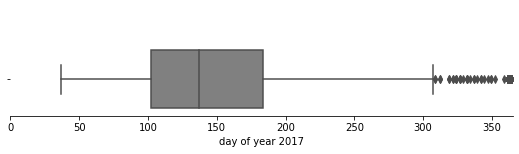

In [11]:

fig, ax = plt.subplots(figsize=(9,2))
seaborn.boxplot(x=doy_stop,orient="h",ax=ax, color="gray")
seaborn.despine(offset=0.5, left=True)
ax.set_xlabel("day of year 2017")
ax.set_ylabel("")
ax.set_xlim(0,365)
t = np.linspace(0,360,4)
ax.set_ylim(-.5,1)
ys = [0.55,0.75,0.55,0.75]
#ax.set_xticks(doys)
#ax.set_xticklabels(dates, rotation=20, ha='right')
fig.savefig("/tmp/violin.pdf",dpi=300,bbox_inches='tight')

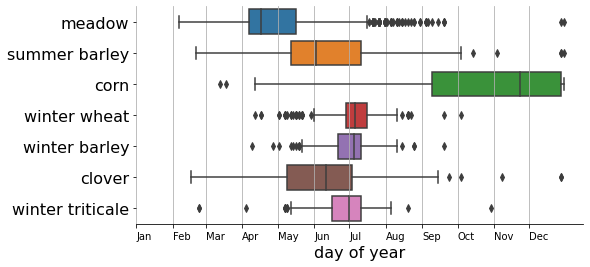

In [12]:
import seaborn
import matplotlib.pyplot as plt


doys_months = [datetime.datetime(2017,m,1).timetuple().tm_yday for m in range(1,13)]
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]


labels_names = ["meadow", "summer barley", "corn", "winter wheat", "winter barley", "clover", "winter triticale"]

fig, ax = plt.subplots(figsize=(8,4))
seaborn.boxplot(x=doy_stop,y=stats["targets"][:,0],orient="h",ax=ax)
ax.set_yticklabels(labels_names, fontsize=16)
ax.set_xlabel("day of year", fontsize=16)
ax.xaxis.grid(True)
ax.set_xticks(doys_months)
ax.set_xticklabels(months, ha="left")
seaborn.despine(left=True)
fig.savefig("/home/marc/projects/re-elects/images/phenology/bavariancrops.pdf", transparent=True, bbox_inches="tight")

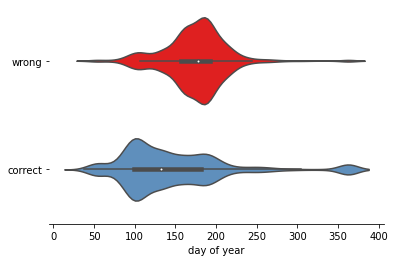

In [20]:
canard = "#007480"
grosseile = "#b51f1f"
rouge = "#FF0000"
leman = "#00A79F"
acier = "#4F8FCC"

correct = stats["predictions_at_t_stop"][:,0] == stats["targets"][:,0]

fig, ax = plt.subplots(figsize=(6,4))
seaborn.violinplot(x=doy_stop,y=correct,orient="h",ax=ax, palette=[rouge,acier])
ax.set_yticklabels(["wrong", "correct"])
seaborn.despine(left=True)
ax.set_xlabel("day of year")
fig.savefig("/tmp/correctwrongbzhviolin.pdf")

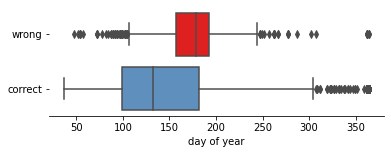

In [21]:
fig, ax = plt.subplots(figsize=(6,2))
seaborn.boxplot(x=doy_stop,y=correct,orient="h",ax=ax, palette=[rouge,acier])
ax.set_yticklabels(["wrong", "correct"])
seaborn.despine(left=True)
ax.set_xlabel("day of year")
fig.savefig("/tmp/correctwrongbzhboxplotbavariancrops.pdf", bbox_inches="tight")

In [19]:
mean_correct = doy_stop[correct].mean()
mean_wrong = doy_stop[~correct].mean()
std_correct = doy_stop[correct].std()
std_wrong = doy_stop[~correct].std()

Ts = stats["seqlengths"]
t_stop = stats["t_stop"][:,0]
earliness = 1-(t_stop / Ts)

from scipy import stats as st
print(st.ks_2samp(doy_stop[correct], doy_stop[~correct]))

print(f"correct {mean_correct} +- {std_correct}")
print(f"correct {mean_wrong} +- {std_wrong}")

KstestResult(statistic=0.41400987709331255, pvalue=2.55351295663786e-15)
correct 147.41406133133881 +- 68.7776270764918
correct 173.71099290780143 +- 38.350725899626966


In [22]:
correct.sum()


6685

In [25]:
(~correct).sum()

1128